Dear Readers,

In this article I am going to take you through a preliminary analysis of correlations in 4 different flavours, progressively increasing in difficulty and explaining their uses within trading systems. I discuss their importance and difference's with respect to two famously related pairs. Gold and Silver.

Gold and Silver are two precious metals as I'm sure you know. They tend to move closely together based on history. This is because they are used as a hedge for inflation (store of value), within technology (electronic components, batteries, etc) and also as a flight to safety from a fragile monetary system (see Rome). Both these metals have been used for thousands of years and throughout time have shown a core fundamental process to which they move together...more on this later...

For now we focus on correlations. Namely what is it, why it is important and how we can use correlations between assets to design trading strategies from. Although I won't be directly covering that in my articles since ideas are cheap but implemenation is $. 

Sample correlation follows a simple formula;
rho = covar(x,y)/sig(x)sig(y)

That is correlation (rho) between two assets x and y is the covariance between x and y divided by the standard deviation of x and y multiplied together. It measures the relationship to which two assets covariate with respect to their own independent standard deviation. Correlations therefore are bounded between [-1, 1] displaying negative and positive perfect correlations at the lower and upper bounds. Note, correlation is merely a metric used to define pure movements between prices. It is instantaneous and does not reflect a true underlying relationship. For keen readers this is known as causality which will lead into cointegration covered in part 2.

In this article we cover 4 types of correlation estimation procedures. First the stationary constant correlation this being the the spearmans rank and pearson correlation formula. Next a rolling correlation with variable window size. Thirdly a DCC model extracted from a GARCH(1,1) model. Finally we cover a unique case of stochastic correlation within an Ornstein-Uhlenbeck process. This has applications within Quanto pricing, basket options and pairs trading.

All code is written by the author and is open-source. Feel free to download the files and have a go yourself. This article is all for education and sharing of ideas, if you have any notes or suggestions please feel free to contact me at the following email address: ....





To start, let's read in our data set. This data was extracted from Yahoo Finance then cleaned to make it "acceptable" for python dataframes (no missing values, no holidays).

We parse in the dataset using pandas, set parse_dates = True so python knows this is a datetime and index on this column (index_col = 0).

In addition it is apt to understand the ETF's which we are analysing. The tickers GLD and SLV are ETFs on silver and gold. They have their quirks and the KID can be found in the following links;

GLD:

SLV:

Therefore they are not trading physical but infact a "paper" version of this. We won't be going into what this means for the actual market of silver and gold but it's important to note here.

In [1]:
import pandas as pd
import matplotlib
%matplotlib inline
df = pd.read_csv("../Pdata/commodity_close_prices", parse_dates = True, index_col = 0)
print(df)

ImportError: DLL load failed: The specified module could not be found.

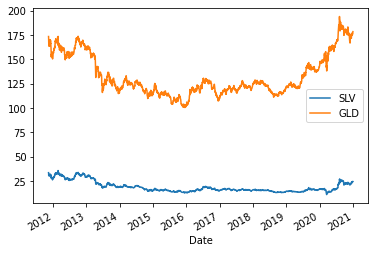

In [4]:
slv_gld = df[['SLV', 'GLD']]
slv_gld.plot()

Not too informative right? We cant even begin to understand the data with this difference in price. Let's reindex at 100 and review the time series

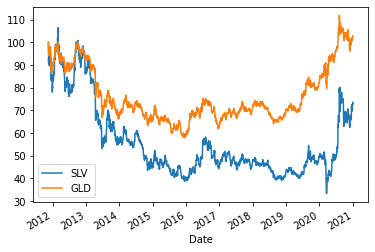

In [5]:
import matplotlib.pyplot as plt
slv_gld = df[['SLV', 'GLD']]
first_row = slv_gld.iloc[0,:]
df_re_index = (slv_gld/first_row)*100
df_re_index.plot()
plt.legend()
plt.show()

Now thats better. From the reindexed graph starting on 2011-11-15 we can see that the two price series follow similar peak to trough with a noticeable dislocation occuring in Mar'20...something happened then...must've been on the news...something about 'Jina'?

Just to make sure lets also plot the GLD to SLV ratio.

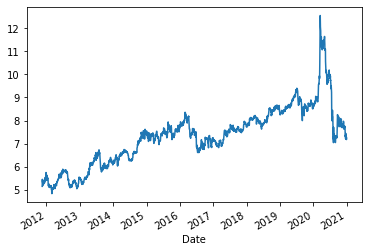

In [6]:
ratio = df['GLD']/df['SLV']
ratio.plot()

Observing the ratio throughout time we notice that Gold becomes signficantly overpriced with respect to Silver correcting slightly from the beggining of 2016 until midway and again after the large spike in Feb-March 2020.

### CORRELATION EXTRACTION ###

We attempt 4 approaches

- Static Correlations

- Rolling Correlations

- DCC - GARCH(1,1) as in Engle RF. Dynamic Conditional correlation: a simple class of multivariate GARCH 2002

- Stochastic correlation under the OU process as is Teng, Ehrhardt and Gunther (2016)

For the purposes of cross-examination we deal with just SLV and GLD to start    



Note: this applies the correlation over the entire window of the observed data

In [7]:
from scipy.stats import pearsonr
corr_p, _ = pearsonr(df.SLV, df.GLD)
print('Pearsons correlation: %.3f' % corr_p)

Pearsons correlation: 0.753


In [8]:
from scipy.stats import spearmanr
corr_s, _ = spearmanr(df.SLV, df.GLD)
print('Spearman correlation: %.3f' % corr_s)

Spearman correlation: 0.713


Now we examine rolling correlations and plot them

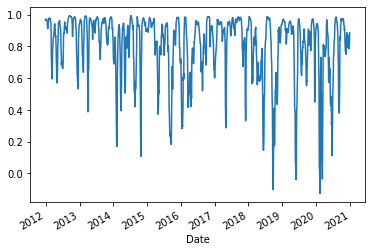

In [4]:
win_30 = df.SLV.rolling(30).corr(df.GLD).dropna()
win_30.plot()

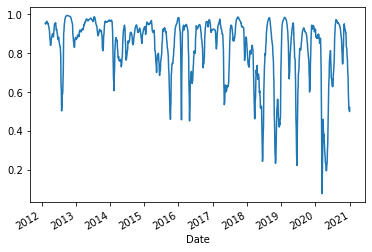

In [5]:
win_60 = df.SLV.rolling(60).corr(df.GLD).dropna()
win_60.plot()


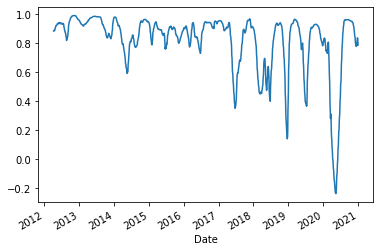

In [6]:
win_100 = df.SLV.rolling(100).corr(df.GLD).dropna()
win_100.plot()

We note that as we increase the window size, the curves become smoother and we extract a less noisy signal

In addition there are spikes in the rolling correlations indicative of a break in pattern. To observe 

We can obtain the DCC model via GARCH and cholesky decomposition at each forecast to derive the conditional correlation.

Extracting the step-wise covariance matrix and solving for the correlations at each time step.
We save these and plot the values along with density plots.


In [2]:
# we need to calculate the log-returns between our variables first
import numpy as np
import datetime as dt
from dcc import DCC
df_l_ret = np.log(df/df.shift(1))*100
rt = df_l_ret[['SLV', 'GLD']]
rt.to_csv("../Pdata/log_returns.csv")
window_1 = 30
window_2 = 60
window_3 = 100
n_days = 1
i = DCC()
sample = rt[1000:]


In [12]:
# Here we are going to test the three processes on 3 different cores to increase computation time
import multiprocessing

def PooledProcesses():
    dist = 'norm'
    PROCESSES = 3
    with multiprocessing.Pool(PROCESSES) as pool:
        params = [ (sample, window_1, n_days, dist) , (sample, window_2, n_days, dist) , (sample, window_3, n_days, dist)]
        results = [pool.apply_async(i.conditional_corr, p) for p in params]
        return results[0].get(), results[1].get(), results[2].get()

series_1, series_2, series_3 = PooledProcesses()



In [13]:
errors_1 = pd.DataFrame(series_1, columns = [f'cond_rho_{window_1}', f'spearman_rho_{window_1}', f'error'], index = sample[window_1:].index)
errors_2 = pd.DataFrame(series_2, columns = [f'cond_rho_{window_2}', f'spearman_rho_{window_2}', f'error'], index = sample[window_2:].index)
errors_3 = pd.DataFrame(series_3, columns = [f'cond_rho_{window_3}', f'spearman_rho_{window_3}', f'error'], index = sample[window_3:].index)


In [14]:
errors_1.to_csv("../Pdata/DCC_30")
errors_2.to_csv("../Pdata/DCC_60")
errors_3.to_csv("../Pdata/DCC_100")

In [15]:
s1 = pd.read_csv("../Pdata/DCC_30", parse_dates = True, index_col =0)
s2 = pd.read_csv("../Pdata/DCC_60", parse_dates = True, index_col = 0)
s3 = pd.read_csv("../Pdata/DCC_100", parse_dates = True, index_col = 0)

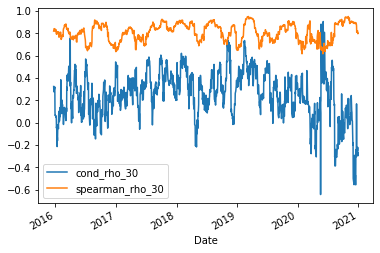

In [16]:
s1[['cond_rho_30', 'spearman_rho_30']].plot()

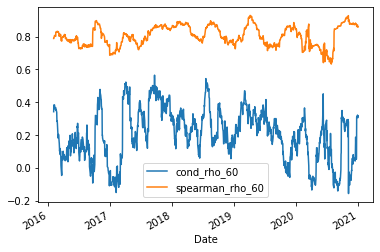

In [17]:
s2[['cond_rho_60', 'spearman_rho_60']].plot()

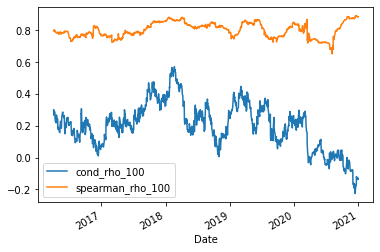

In [18]:
s3[['cond_rho_100', 'spearman_rho_100']].plot()

Conditionally we can observe that the relationship between GLD and SLV as a conditionally positive correlation. We note significant breaks in this correlation at the given dates.




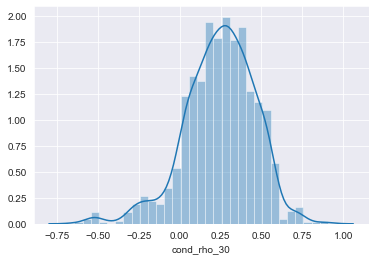

In [23]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(s1[f'cond_rho_{window_1}'])
# plotting the empirical density function of the dynamic conditional correlation model

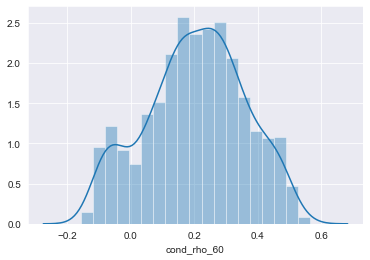

In [24]:
sns.set_style('darkgrid')
sns.distplot(s2[f'cond_rho_{window_2}'])

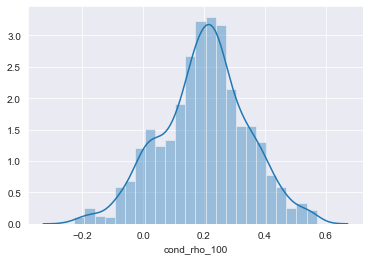

In [25]:
sns.set_style('darkgrid')
sns.distplot(s3[f'cond_rho_{window_3}'])

Next we attempt to model the stochastic correlation of two correlated bronwian motions.

This endeavour is a little bit tricky and involves more steps, maths and coffee. The code for this function will be included in the file; stoch_corr.py, within it the class ModifiedOU is called for calibration and estimation of the stochastic correlation under the assumption of two correlated Brownian Motions.

In short it involves fitting a transition density function to the historical correlations to estimate the parameters k, mu and sigma being the mean, drift and volatility respectively of the correlation process.

We assume in this model that the correlation between assets one and two is a tangential transformation of an OU process  
where p_t = tanh(X_t) and dX_t = k(mu - tanh(X_t))dt + sigma*dW_t 
where X_t is a mean reverting stochastic process on the correlations



In [3]:
import stoch_corr
from stoch_corr import ModifiedOU as mou

i = mou()

scp_params_30 = i.get_coeff(sample, window_1, 1/252)
#scp_params = i.compute_correlation_values(sample, 30)  #call this to extract the rolling hsitorical correlation used for calibration of the stochastic correlation 

NameError: name 'scp_params' is not defined

In [4]:
print(scp_params_30)

(1.1715505437136082, 7.592163938851404, 0.9538849629579008)


In [7]:
scp_params_60 = i.get_coeff(sample, window_2, 1/252)
#scp_params = i.compute_correlation_values(sample, 30)  #call this to extract the rolling hsitorical correlation used for calibration of the stochastic correlation process


KeyboardInterrupt: 

In [ ]:
print(scp_params_60)

In [ ]:
scp_params_100 = i.get_coeff(sample, window_3, 1/252)
#scp_params = i.compute_correlation_values(sample, 30)  #call this to extract the rolling hsitorical correlation used for calibration of the stochastic correlation process
print(scp_params_100)

In [ ]:
 # storing into dictionaries
 trained_params = { 
     '30-day' : {'mu': scp_params_30[0], 'k': scp_params_30[1], 'sigma' : scp_params_30[2]}
     '60-day' : {'mu': scp_params_60[0], 'k': scp_params_60[1], 'sigma' : scp_params_60[2]}
     '100-day' : {'mu': scp_params_100[0], 'k': scp_params_100[1], 'sigma' : scp_params_100[2]} }

In [13]:
# 1st instance iteration

def corr_pred(k, mu, sigma, X0, dt):
    X_t = X0*np.exp(-k*dt) + k*mu*( 1-np.exp(-k*dt) ) 
    rho = np.arctanh(X_t)
    return rho

{'100-day': {'mu': 1.113654588392757,
  'k': 180.09760104687268,
  'sigma': 2.5068497526028395}}